Implémentation de résolution numérique approchée des 2 équations couplées du mouvement de précession :
$\frac{dv_x}{dt} = \omega v_y(t), 
\frac{dv_y}{dt} = -\omega v_x(t), 
v_x(0) = V_0,
v_y(0) = 0$
à l'aide de la méthode de descente de gradients sur la fonction d'erreur


In [268]:
#imports
from numpy import pi, cos, sin, dot, zeros, linspace, arange, matmul, concatenate
from numpy.random import randn

Paramètres du modèle

In [269]:
#nombre de coefficients de Fourier ajustables
M = 10
M_range = arange(M) +1

# nombre de points pour la variable indépendante
N = 100
T = linspace(0,1,N)

Paramètres du problème

In [270]:
W = 2*pi #pulsation
V0 = 1 #vitesse initiale

Calculs des vecteurs des cosinus et sinus qui seront souvent utilisés

In [271]:
#matrice de coefficients (m*W*T[i]) de taille NxM
#avec première coordonnée i, et deuxème m
m_w_T = W*matmul(T.reshape((N,1)), M_range.reshape((1,M)))
cos = cos(m_w_T)
sin = sin(m_w_T)

Définition du gradient

In [272]:
def calcGrad(A,B) :
    #calcule le gradient de l'erreur par rapport aux
    #2 vecteurs de paramètres A et B
    grad_A = zeros((M))
    grad_B = zeros((M))

    for i in range(N) :
        #valeurs de vx et vy à l'instant T[i]
        vx = V0 + dot(A, cos[i]-1) + dot(B, sin[i])
        vy = - dot(A, sin[i]) + dot(B, cos[i]-1)

        #valeurs des dérivées de vx et vy à l'instant T[i]
        dvx = W*(-dot(M_range*A, sin[i]) + dot(M_range*B, cos[i]))
        dvy = W*(-dot(M_range*A, cos[i]) - dot(M_range*B, sin[i]))

        #différences
        ex = dvx - W*vy
        ey = dvy + W*vx

        #on incrémente les gradients
        #pour A
        dex_dA = W*(1-M_range)*sin[i]
        dey_dA = W*((1-M_range)*cos[i]-1)
        grad_A += ex*dex_dA + ey*dey_dA
        #pour B
        dex_dB = W*((M_range-1)*cos[i]+1)
        dey_dB = W*(1-M_range)*sin[i]
        grad_B += ex*dex_dB + ey*dey_dB

    return grad_A, grad_B

Définition de l'erreur

In [273]:
def calcErreur(A, B) :

    erreur = 0
    for i in range(N) :
        #valeurs de vx et vy à l'instant T[i]
        vx = V0 + dot(A, cos[i]-1) + dot(B, sin[i])
        vy = - dot(A, sin[i]) + dot(B, cos[i]-1)

        #valeurs des dérivées de vx et vy à l'instant T[i]
        dvx = W*(-dot(M_range*A, sin[i]) + dot(M_range*B, cos[i]))
        dvy = W*(-dot(M_range*A, cos[i]) - dot(M_range*B, sin[i]))

        #différences
        ex = dvx - W*vy
        ey = dvy + W*vx

        erreur += ex**2 + ey**2

    return erreur/2

Calcul matriciel du gradient

In [274]:
d = zeros(2*M)
for l in range(1,M+1) :
    for i in range(N) :
        d[l-1] += (1-l)*cos[i,l-1]-1
        d[l-1+M] += (1-l)*sin[i,l-1]

d*=W**2*V0


mat = zeros((2*M,2*M))

for l in range(1,M+1) :
    for m in range(1,M+1) :
        for i in range(N) :
            mat[l-1,m-1] += (1-l)*(1-m)*sin[i,m-1]*sin[i,l-1]
            mat[l-1,m-1] += ((1-l)*cos[i,l-1]-1)*((1-m)*cos[i,m-1]-1)

            mat[l-1,m-1+M] += (1-l)*sin[i,l-1]*((m-1)*cos[i,m-1]+1)
            mat[l-1,m-1+M] += (1-m)*sin[i,m-1]*((1-l)*cos[i,l-1]-1)

            mat[l-1+M,m-1] += ((l-1)*cos[i,l-1]+1)*(1-m)*sin[i,m-1]
            mat[l-1+M,m-1] += (1-l)*sin[i,l-1]*((1-m)*cos[i,m-1]-1)

            mat[l-1+M,m-1+M] += ((l-1)*cos[i,l-1]+1)*((m-1)*cos[i,m-1]+1)
            mat[l-1+M,m-1+M] += (1-l)*(1-m)*sin[i,m-1]*sin[i,l-1]

mat *= W**2



def calcGrad_mat(A, B, mat, d) :
    P = concatenate((A,B))
    G = matmul(mat, P) + d
    return G[:M], G[M:]

Paramètres d'apprentissage

In [275]:
alpha = 6.0906090609060915e-06 #taux d'apprentissage pour la descente de gradients
epochs = 10000 #nombre d'itération

#initialisation des coefficients
A = randn((M))
B = randn((M))

Entraînement

In [276]:
E = [] #evolution de l'erreur

for k in range(epochs) :
    if k%(epochs//10)==0 :
        print("\nCoefficients après",k,"itérations :\n",A,"\n", B)
    
    if k%(epochs//100)==0 :
        E.append(calcErreur(A,B))

    grad_A, grad_B = calcGrad_mat(A, B, mat, d)#calcGrad(A,B)#
    A -= alpha*grad_A
    B -= alpha*grad_B


E.append(calcErreur(A,B))


Coefficients après 0 itérations :
 [ 0.39506675  0.83012114  1.26442215 -0.93224902  0.66544973 -0.43407907
 -0.39873674 -0.30868579  1.01896169 -0.15802091] 
 [ 2.34932005 -2.16326327 -0.04792779 -1.22542098  0.02607207  0.31908906
 -1.79563459 -0.44219666  0.37074503 -0.14613889]

Coefficients après 1000 itérations :
 [ 9.99684871e-01  1.52638671e-04  2.68829883e-05  1.08566312e-05
  5.60666663e-06  3.18568381e-06  1.78002806e-06  7.07711667e-07
 -7.06573471e-07 -1.48492522e-05] 
 [ 9.97348923e-04 -4.86598802e-04 -8.79959824e-05 -3.75520513e-05
 -2.14515699e-05 -1.45999974e-05 -1.15047036e-05 -1.07480964e-05
 -1.35336445e-05 -7.45261148e-05]

Coefficients après 2000 itérations :
 [ 9.99999887e-01  5.48856193e-08  9.68120301e-09  3.92259405e-09
  2.03887798e-09  1.17387408e-09  6.77276410e-10  3.08685926e-10
 -1.53299164e-10 -4.56156409e-09] 
 [ 3.58587381e-07 -1.74851225e-07 -3.15545512e-08 -1.34099480e-08
 -7.60640105e-09 -5.11973810e-09 -3.96804147e-09 -3.62038469e-09
 -4.41366096

Affichage des résultats

In [277]:
print()
print("Coefficients finaux après",epochs,"itérations :",A,B)


Coefficients finaux après 10000 itérations : [1.00000000e+00 2.31642595e-15 5.47229545e-16 2.47035892e-16
 1.31952109e-16 8.02547092e-17 5.62497054e-17 3.99526527e-17
 3.29743420e-17 1.67037104e-17] [ 1.92352154e-32  1.08369338e-31 -3.22199651e-31 -1.03243768e-31
 -3.19931664e-31  1.07694257e-31  4.42961405e-32  2.94077447e-32
  7.13596180e-32  1.73806286e-31]


Affichage graphique de l'erreur

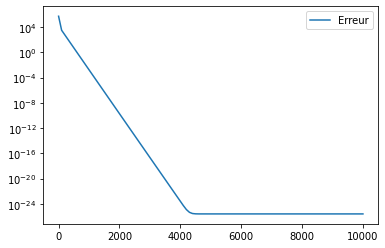

In [278]:
from matplotlib.pyplot import plot, show, yscale, legend, savefig

plot([100*k for k in range(101)], E, label = 'Erreur')
yscale('log')
legend()
#savefig("comparaison_erreurs_selon_alpha_1D.jpg")
show()